In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

from scipy.optimize import curve_fit

# for distribution fitting
from astropy import modeling as am

# import text processing libraries for keywords processing
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet') # download for lemmatization
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import amz

glob = globals()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Zixing\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Zixing\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Zixing\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [352]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [305]:
import os
cwd = os.getcwd()
cwd

'E:\\Data_Science_Coursework\\Amazon_Sales_Analysis'

In [306]:
#get the list of files saved for machine learning
path_to_learn = ('E:\\Data_Science_Coursework\\Amazon_Sales_Analysis\\Moon_Star_Earrings\\Learning Dataset\\')
files = os.listdir(path_to_learn)
len(files)

16

In [307]:
#Put all data into one dataframe called ml_set
ml_set = pd.read_csv(path_to_learn + files[0])
for i in range(1, len(files)):
    new_set = pd.read_csv(path_to_learn + files[i])
    ml_set = ml_set.append(new_set, ignore_index = True)

In [310]:
ml_set.shape

(1277, 22)

In [367]:
myown = pd.read_csv('Moon_Star_Earrings/Helium_10_Xray_export_myown_Asymmetrical Star Earrings.csv')
myown = x_ray_clean(myown)

C:\Users\Zixing\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Zixing\anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [311]:
def x_ray_clean(df, sizetiercatnum = {'Small Standard-Size': 1, 'Large Standard-Size': 2, np.nan: 0}):
    if 'Unnamed: 20' in df.columns or 'Unnamed: 21' in df.columns:
        df = df.drop(columns = ['Unnamed: 20', 'Unnamed: 21'])
    # Handle the price column
    df.dropna(subset = ['Price', 'Title'], inplace = True)
    if  df.Price.dtypes == 'object':
            df.Price = df.Price.astype(str).str.replace(',', '').astype(float)
    # Handle the Fulfillment column
    df['Fulfillment '][df['FBA fee'] == 0] = 'MFN'
    df['Fulfillment '].fillna('FBA', inplace = True)
    # Handle the Sales, Revenue, BSR, Review count, Review Velocity column
    df[['Sales','Revenue', 'BSR', 'Review Count', 'Review Velocity']] = df[['Sales','Revenue', 'BSR', 'Review Count', 'Review Velocity']].apply(lambda x: data_clean1(x))
    df.BSR.replace(to_replace = 0, value = df.BSR.max(), inplace = True)
    #Handle the Dimensions column
    df.Dimensions.fillna(inplace = True, method = 'pad')
    df.Dimensions.fillna(inplace = True, method = 'bfill')
    #Handle Weight and images column
    df['Weight'].fillna(df['Weight'].median(), inplace = True)
    df['Images'].fillna(df['Images'].median(), inplace = True)
    # Handle the Images column
    df.Images.fillna(df.Images.median(), inplace= True)
    # Handle the listing creation date
    df['Listing Creation Date'].fillna(inplace = True, method = 'pad')
    df['Listing Creation Date'].fillna(inplace = True, method = 'bfill')

    df = df.sort_values(by = ['Sales'], axis = 0, ascending = False)
    df = df.reset_index(drop = True)
    df['Review Ratio'] = df['Sales']/df['Review Velocity']
    df['Review Ratio'][df['Review Ratio'] == np.inf] = 0
    df['Review Ratio'].fillna(0, inplace  =True)
    df['Volume'] = 0.00
    for i, dimen in enumerate(df.Dimensions):
        firstx = dimen.find('x')
        secdx = dimen.find('x', firstx+1)
        l = float(dimen[:firstx])
        w = float(dimen[firstx+1:secdx])
        h = float(dimen[secdx+1:])
        df.at[i, 'Volume'] = l*w*h
    df['Size Tier Numeric'] = df['Size Tier'].apply(lambda x: sizetiercatnum[x])
    ful_num = {'MFN': 2, 'FBA': 1, 'AMZ': 3, np.nan: 0}
    df['FF Numeric'] = df['Fulfillment '].apply(lambda x: ful_num[x])
    today= pd.to_datetime('today')
    df['Listing Creation Date'] = pd.to_datetime(df['Listing Creation Date'], format = '%m/%d/%Y')
    df['Listing Length'] = today - df['Listing Creation Date']
    df['Listing Length'] = df['Listing Length'].transform(lambda x: x.days)
    # Fill the Listing Length with the median
    df['Listing Length'].fillna(df['Listing Length'].median(skipna = True), inplace = True)
    return df

In [312]:
# Clean the data
ml_set = x_ray_clean(ml_set, sizetiercatnum = {'Small Standard-Size': 1, 'Large Standard-Size': 2, 'Small Oversize':3,\
                                                    np.nan: 0})

C:\Users\Zixing\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Zixing\anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [313]:
ml_set.columns

Index(['ASIN', 'Brand', 'Title', 'Category', 'BuyBox', '#', 'Fulfillment ',
       'Price', 'FBA fee', 'Sales', 'Revenue', 'BSR', 'Rating', 'Review Count',
       'Review Velocity', 'Dimensions', 'Weight', 'Size Tier', 'Images',
       'Listing Creation Date', 'Review Ratio', 'Volume', 'Size Tier Numeric',
       'FF Numeric', 'Listing Length'],
      dtype='object')

In [315]:
X_lst = ['Title', 'Price', 'FBA fee', 'Rating', 'Review Count', 'Weight', 'Images', 'Review Ratio', 'Size Tier Numeric',\
       'Volume', 'Size Tier Numeric', 'FF Numeric', 'Listing Length']
X = ml_set[X_lst]
y = ml_set.Sales.values

In [404]:
myown_x = myown[X_lst]
myown_y = myown.Sales.values

In [316]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [366]:
def x_prep(X, vect, tfidf, train_test):
    title = X.Title.values
    if train_test == 'train':
        title_counts = vect.fit_transform(title)
        title_tfidf = tfidf.fit_transform(title_counts)
    else:
        title_counts = vect.transform(title)
        title_tfidf = tfidf.transform(title_counts)
    X.drop(['Title'], axis =1, inplace = True)
    X_conc = np.concatenate((title_tfidf.toarray(), X.values), axis = 1)
    return X_conc

In [369]:
myown_X = x_prep(myown_x, vect = vect, tfidf = tfidf, train_test = 'test')

C:\Users\Zixing\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [317]:
title_train = X_train.Title.values
title_test = X_test.Title.values

In [318]:
# Now we split the title into columns for machine learning
vect = CountVectorizer(tokenizer=amz.tokenize)
tfidf = TfidfTransformer()

In [319]:
title_train_counts = vect.fit_transform(title_train)
title_train_tfidf = tfidf.fit_transform(title_train_counts)
X_train.drop(['Title'], axis =1, inplace = True)
X_train_conc = np.concatenate((title_train_tfidf.toarray(), X_train.values), axis = 1)

C:\Users\Zixing\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [321]:
X_train_conc.shape

(1144, 1511)

In [338]:
title_test_counts = vect.transform(title_test)
title_test_tfidf = tfidf.transform(title_test_counts)
X_test.drop(['Title'], axis =1, inplace = True)
X_test_conc = np.concatenate((title_test_tfidf.toarray(), X_test.values), axis = 1)

C:\Users\Zixing\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Use regression of all values to fit the sales
- Linear regression:
    - Ordinary Least Squares
    - Elastic-Net
- Polynomial regression
- Random Tree 

In [332]:
y_train

array([1.855e+03, 1.932e+03, 0.000e+00, ..., 1.000e+00, 1.500e+01,
       1.000e+00])

In [324]:
np.all(np.isfinite(X_train_conc))

True

In [343]:
OLS = linear_model.LinearRegression()
enet = linear_model.ElasticNet()
poly3 = PolynomialFeatures(degree=2)
#X_train_3 = poly3.fit_transform(X_train_conc)
RForest = RandomForestRegressor()

Linear

In [340]:
OLS.fit(X_train_conc, y_train)
y_pred = OLS.predict(X_test_conc)

r2_score(y_pred , y_test)

-0.02094274684592823

Elastic-Net for Linear

In [341]:
enet.fit(X_train_conc, y_train)
y_pred = enet.predict(X_test_conc)
r2_score(y_pred , y_test)

0.23414025994036836

Random Forest

In [344]:
RForest.fit(X_train_conc, y_train)
y_pred = RForest.predict(X_test_conc)
r2_score(y_pred , y_test)

0.7891821194508326

Decision Tree

In [346]:
DTree = DecisionTreeRegressor()
DTree.fit(X_train_conc, y_train)
y_pred = DTree.predict(X_test_conc)
r2_score(y_pred , y_test)

0.8208201610830448

Support Vector Regressor

In [353]:
svr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
svr.fit(X_train_conc, y_train)
y_pred = svr.predict(X_test_conc)
r2_score(y_pred , y_test)

-14961289.552900324

With an initial screening, we can see decision tree and random forest gives the closest estimations. Now we use a grid search to find the best parameters for the estimation. 

In [358]:
ensemble_clf = [RForest, DTree]
params1 = {"n_estimators":range(50, 300, 50),"max_depth": range(5,20,5), 'ccp_alpha': (0, 0.005, 0.01, 0.015, 0.02)}
params2 = {'criterion':['mse', 'friedman_mse', 'mae'], 'min_samples_split': range(2, 10, 4), 'ccp_alpha': (0, 0.005, 0.01, 0.015, 0.02)}
parameters_list = [params1, params2]
#for i in range(2):
grid = GridSearchCV(estimator=ensemble_clf[0], param_grid=parameters_list[0], 
                      n_jobs=-1, cv=3, verbose=3)
grid.fit(X_train_conc, y_train)


Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed: 16.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [360]:
RForest_best = grid.best_estimator_

In [362]:
grid.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.005, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [361]:
y_pred = RForest_best.predict(X_test_conc)
r2_score(y_pred , y_test)

0.7707941786636126

In [363]:
grid_DTree = GridSearchCV(estimator=ensemble_clf[1], param_grid=parameters_list[1], 
                      n_jobs=-1, cv=3, verbose=3)
grid_DTree.fit(X_train_conc, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   35.9s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'ccp_alpha': (0, 0.005, 0.01, 0.015, 0.02),
                         'criterion': ['mse', 'friedman_mse', 'mae'],
                  

In [364]:
grid_DTree.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.01, criterion='mae', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [365]:
DTree_best = grid_DTree.best_estimator_
y_pred = DTree_best.predict(X_test_conc)
r2_score(y_pred , y_test)

0.786340583518028

In [370]:
DTree_best.predict(myown_X)

array([15., 15., 15., 15., 15., 15.])

In [371]:
myown_y

array([9, 9, 9, 9, 9, 9], dtype=int64)

In [372]:
grid_DTree.predict(myown_X)

array([15., 15., 15., 15., 15., 15.])

In [373]:
DTree.predict(myown_X)

array([14., 14., 14., 14., 14., 14.])

In [374]:
RForest.predict(myown_X)

array([12.21, 12.2 , 12.23, 12.3 , 12.45, 12.3 ])

In [400]:
myown_x.head()

,Price,FBA fee,Rating,Review Count,Weight,Images,Review Ratio,Size Tier Numeric,Volume,Size Tier Numeric,FF Numeric,Listing Length
0,4.85,3.47,5,4,0.03,4,0.0,1,1.152,1,1,180
1,4.85,3.47,5,6,0.01,5,0.0,1,0.651,1,1,270
2,4.85,3.47,5,8,0.01,1,0.0,1,2.500,1,1,360
3,4.85,4.46,5,10,0.02,7,0.0,1,2.500,1,1,450
4,4.85,4.46,5,12,0.01,5,0.0,1,1.674,1,1,540


In [405]:
myown_x['Listing Length'] = 90*np.arange(2, 8)

myown_x['Review Count'] = 2*np.arange(2, 8)

C:\Users\Zixing\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Zixing\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [406]:
myown_X = x_prep(myown_x, vect = vect, tfidf = tfidf, train_test = 'test')

C:\Users\Zixing\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [408]:
time_sales = DTree.predict(myown_X)

Text(0.5, 1.0, 'Predicted Sales of the item with time')

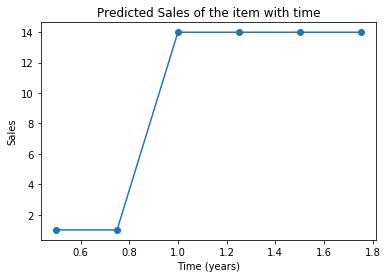

In [411]:
plt.plot(0.25*np.arange(2, 8), time_sales, 'o-')
plt.xlabel('Time (years)')
plt.ylabel('Sales')
plt.title('Predicted Sales of the item with time')